# Hyperparameter optimization for Neural Networks using Surrogate Optimization
In this jupyter notebook, we implement a simple Recurrent Neural Network (RNN) to do text generation / prediction on the work of Shakespeare, as shown in Andrej Karpathy's [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). The implementation is heavily borrowed from [tensorflow's example](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/text_generation.ipynb) on the same neural network. The aim of this notebook is not to build this RNN network, which is already accomplished quite well by the tensorflow example, but infact use this as an example for hyperparameter optimization.

Hyperparameter optimization can be very time consuming. Usually, there is no easy way for doing hyperparameter search, except randomly trying multiple values of different hyperparameters. However, randomly searching for the best hyperparameter set is not very effcient, since training hte model even once can be very computationally expensive. Thus, we use Surrogate Optimization to do the hyperparameter search instead. Surrogate optimization is a global optimization techinique which aims to find the optimal while evaluating the cost function as few number of times as possible.

Before we being the hyperparameter optimization, we need to implement the RNN architecture first. This is done below.

## Text Generation with RNN
### Data Reading and Preprocessing

In [1]:
import tensorflow as tf
import numpy as np
import os
import time
from matplotlib import pyplot as plt

In [2]:
# download the dataset
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

In [3]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print ('Length of text: {} characters'.format(len(text)))
print('First 250 characters:\n', text[:250])

Length of text: 1115394 characters
First 250 characters:
 First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



Before working with this data, it needs to be vectorized, by converting the text into numerical respresentation.

In [4]:
# The unique characters in the file
vocab = sorted(set(text))
print ('{} unique characters'.format(len(vocab)))

# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]), end=' ')
print('  ...\n}')

65 unique characters
{
  '\n':   0,   ' ' :   1,   '!' :   2,   '$' :   3,   '&' :   4,   "'" :   5,   ',' :   6,   '-' :   7,   '.' :   8,   '3' :   9,   ':' :  10,   ';' :  11,   '?' :  12,   'A' :  13,   'B' :  14,   'C' :  15,   'D' :  16,   'E' :  17,   'F' :  18,   'G' :  19,   ...
}


### The Prediction Task
The prediction task is as follows: given `seq_length` of input characters, predict another sequence of characters of the same length, with with same characters everywhere except one character shifted to the right. In this way, we are predicting next character at every iteration.

In [5]:
# The maximum length sentence we want for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

# Creat sequences of len seq_len+1 (both input and output)
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

# Create input, output pairs from the sequences
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

# print an example
for input_example, target_example in  dataset.take(1):
  print ('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
  print ('Target data:', repr(''.join(idx2char[target_example.numpy()])))

Input data:  'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target data: 'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


In [6]:
# Converting the data into batches invlves shuffling the data and split it into sets of input-output pairs of size BATCH_SIZE
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int32, tf.int32)>

## Setting up Model class for Optimization
Use `tf.keras.Sequential` to define the model. For this simple example three layers are used to define our model:

 * `tf.keras.layers.Embedding`: The input layer. A trainable lookup table that will map the numbers of each character to a vector with embedding_dim dimensions;
 * `tf.keras.layers.GRU`: A type of RNN with size units=rnn_units (You can also use a LSTM layer here.)
 * `tf.keras.layers.Dense`: The output layer, with vocab_size outputs.

The image below, taken from the original Tensorflow example is a great overview of the entire architecture. The parameters of the above three parameter will form the hyperparameters to be optimized using surrogate optimization. To do the optimization, the model needs to be setup as a black box (a class) which just gives back the final loss to be minimized.

![RNN Architecture](Images/text_generation_rnn.png)

In [7]:
from pySOT.optimization_problems import OptimizationProblem

class RNN_Model(OptimizationProblem):
    def __init__(self, vocab_size, batch_size, dataset, lower_bounds, upper_bounds, checkpoint_dir=None):
        super().__init__()
        self.best_loss = np.inf
        self.best_model = None
        self.best_embed_dim, self.best_rnn_units, self.best_num_rnn_layers = None, None, None
        self.vocab_size = vocab_size
        self.batch_size = batch_size
        self.ckpt_dir = checkpoint_dir if checkpoint_dir is not None else './output/checkpoints/'
        self.dataset = dataset
        self.lb = lower_bounds
        self.ub = upper_bounds
        self.dim = 3
        self.int_var = np.array([0,1,2])
        self.cont_var = []

    def build_model(self, embedding_dim, rnn_units, num_rnn_layers=1, batch_size=None):
        layers = [tf.keras.layers.Embedding(self.vocab_size, embedding_dim,
                                    batch_input_shape=[self.batch_size if batch_size is None else batch_size, None])]
        for _ in range(num_rnn_layers):
            layers.append(tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'))
        layers.append(tf.keras.layers.Dense(vocab_size))
        
        model = tf.keras.Sequential(layers)
        return model

    def loss(self,labels, logits):
        return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

    def train(self, embedding_dim, rnn_units, num_rnn_layers=1, epochs=20, verbose=True):
        model = self.build_model(embedding_dim, rnn_units, num_rnn_layers)
        model.compile(optimizer='adam', loss=self.loss)
        history = model.fit(self.dataset, epochs=epochs, verbose=verbose)
        if history.history['loss'][-1] < self.best_loss:
            self.best_loss = history.history['loss'][-1]
            self.best_embed_dim, self.best_rnn_units, self.best_num_rnn_layers = embedding_dim, rnn_units, num_rnn_layers
            model.save_weights(self.ckpt_dir+'best_weights')
        return history.history['loss'][-1]

    def eval(self, x):
        return self.train(int(x[0]), int(x[1]), int(x[2]), verbose=False)

    def infer(self, input_str):
        if self.best_loss is None:
            raise Exception("Model not found. Train model first using RNN_Model.train()")
        model = self.build_model(self.best_embed_dim, self.best_rnn_units, num_rnn_layers=self.best_num_rnn_layers, batch_size=1)
        model.load_weights(tf.train.latest_checkpoint(self.ckpt_dir))
        model.build(tf.TensorShape([1, None]))

        return self.generate_text(model, input_str)

    def generate_text(self, model, start_string, num_generate=1000):
        # Converting our start string to numbers (vectorizing)
        input_eval = [char2idx[s] for s in start_string]
        input_eval = tf.expand_dims(input_eval, 0)

        # Empty string to store our results
        text_generated = []

        # Low temperatures results in more predictable text.
        # Higher temperatures results in more surprising text.
        # Experiment to find the best setting.
        temperature = 1.0

        # Here batch size == 1
        model.reset_states()
        for i in range(num_generate):
            predictions = model(input_eval)
            # remove the batch dimension
            predictions = tf.squeeze(predictions, 0)

            # using a categorical distribution to predict the character returned by the model
            predictions = predictions / temperature
            predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

            # We pass the predicted character as the next input to the model
            # along with the previous hidden state
            input_eval = tf.expand_dims([predicted_id], 0)

            text_generated.append(idx2char[predicted_id])

        return (start_string + ''.join(text_generated))

In [8]:
# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

vocab_size = len(vocab)

## Optimization using pySOT

In [9]:
from pySOT.utils import check_opt_prob
from poap.controller import SerialController, ThreadController, BasicWorkerThread
from pySOT.experimental_design import SymmetricLatinHypercube
from pySOT.surrogate import RBFInterpolant, CubicKernel, LinearTail
from pySOT.strategy import DYCORSStrategy
from pySOT.optimization_problems import OptimizationProblem

In [10]:
maxeval = 40
lb = np.array([32, 256, 1])   # lower bounds for embedding_dim, rnn_units, num_rnn_layers
ub = np.array([512, 2048, 3])  # upper bounds
problem = RNN_Model(vocab_size, BATCH_SIZE, dataset, lower_bounds=lb, upper_bounds=ub, checkpoint_dir='./output/RBF_Interpolant/checkpoints/')

# make sure that the model follows the standard required by pySOT for optimization
check_opt_prob(problem)

# Use a symmetric Latin hypercube with 2d + 1 samples for initialization
exp_des = SymmetricLatinHypercube(dim=problem.dim, num_pts=2*problem.dim+1)

# Use a cubic RBF interpolant with a linear tail as surrogate model
surrogate = RBFInterpolant(dim=problem.dim, kernel=CubicKernel(), tail=LinearTail(problem.dim))

# Use the serial controller (uses only one thread)
# controller = SerialController(objective=problem.eval)
controller = ThreadController()

# Use the sychronous strategy without non-bound constraints
controller.strategy = DYCORSStrategy(
        max_evals=maxeval, opt_prob=problem, asynchronous=True,
        exp_design=exp_des, surrogate=surrogate, num_cand=100*problem.dim, batch_size=1)
num_threads = 2
for _ in range(num_threads):
        worker = BasicWorkerThread(controller, problem.eval)
        controller.launch_worker(worker)

# Run the optimization strategy
result = controller.run()
rbf_loss_history = np.zeros(maxeval)
rbf_loss_history = np.array([o.value for o in controller.fevals if o.value is not None])
print('Best loss: {}, best embed_dim: {}, best rnn_units: {}, best num_rnn_layers: {}'.format(
    problem.best_loss, problem.best_embed_dim, problem.best_rnn_units, problem.best_num_rnn_layers
))

Best loss: 0.8313778042793274, best embed_dim: 33, best rnn_units: 1991, best num_rnn_layers: 1


For comparison, we also run `maxeval` number of training cycles using randomly generated hyperparameters and compare the two approaches.

In [11]:
rand_problem = RNN_Model(vocab_size, BATCH_SIZE, dataset, lower_bounds=lb, upper_bounds=ub, checkpoint_dir='./output/Random/checkpoints/')

rand_ins = np.empty((maxeval, 3))
random_loss_history = []
for i in range(rand_ins.shape[1]):
    rand_ins[:, i] = np.random.randint(lb[i], ub[i], size=maxeval)

for i in range(maxeval):
    random_loss_history.append(problem.eval(rand_ins[i, :]))

print('Best loss: {}, best embed_dim: {}, best rnn_units: {}, best num_rnn_layers: {}'.format(
    problem.best_loss, problem.best_embed_dim, problem.best_rnn_units, problem.best_num_rnn_layers
))

Best loss: 0.8880326747894287, best embed_dim: 218, best rnn_units: 1136, best num_rnn_layers: 2


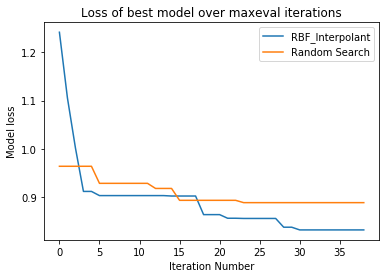

In [12]:
min_rbf, min_rand = [], []
for i in range(1, maxeval):
    min_rbf.append(min(rbf_loss_history[:i]))
    min_rand.append(min(rand_loss_history[:i]))

plt.plot(min_rbf)
plt.plot(min_rand)
plt.title('Loss of best model over maxeval iterations')
plt.xlabel('Iteration Number')
plt.ylabel('Model loss')
plt.legend(['RBF_Interpolant', 'Random Search'])

We see that the surrogate optimization quickly becomes better at selecting good hyperparameters for the neural network than random guessing. The random guessing, in this case, starts with a good initial guess, but within 3 iterations falls behind the surrogate optimization technique. Let's re-load the best models that were trained by each method and quickly perform a sample inference to see the difference. Also, interestingly, the model found using optimization has lesser number of RNN layers, and a smaller embedding dimension.

In [13]:
print('==============RBF Interpolant Optimization==================')
print(problem.infer(u"ROMEO: "))

print('=====================Random Guessing========================')
print(rand_problem.infer(u"ROMEO: "))

==============RBF Interpolant Optimization==================
ROMEO: play,
That hath been a shower of service, woman,
The other son Edward, King of Angelo, and I thank you:
His ands to the Baptista Marght! Bushy, Baworbiox for the mind of Baptistaise?

PETRUCHIO:
Tybalt, here's a wedding-d?

GLOUCESTER:
And hath he be e here so Under barrise death us oft to kill visitether, your worser thee
Made him an roar?
How would you not yet be?
Where she may plain all thesetf her;
Had she must wite the lips: but he was ever too hardly more.

PETRUCHIO:
O, she pardon him,
For he omen.

MENENBEO:
Is you have pill'd me my bosom of the prince, as once
Fif you, Jenus, we will be moved: go fit good and false.

ESCALUS:
Your unit,
And that you shall not wear the goat, ask more import
By last were ladies loss of waterss
And set his agued her!
Away, your judgment, sparrons for the boar,
As if he dwell the better for a Christian ll you know yourselves.

Gaysomeo,
Drawn tun, defended thee of ics, gowet to me

Which one of these two sound better? well... that's for you to decide.